In [1]:
#pip install keras-ordered-neurons

In [2]:
#!pip install tensorflow
#!pip install keras

In [3]:
# Import our dependencies
from datetime import datetime
import os

import pandas as pd
from pandas import concat

import numpy as np
from numpy import array

import sklearn as skl
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

from xgboost import XGBRegressor

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import pyplot

import tensorflow as tf
from tensorflow.keras import layers, models, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow import keras
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


import seaborn as sns

import keras_tuner as kt
from keras.models import Sequential
from keras.layers import Dense

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

from math import sqrt




In [4]:
# Read the dataset
pos_data = pd.read_csv("Hist_POS_data.csv")

In [5]:
pos_data.head()

,MemberDate,Year,Week,UPC12digit,Brand,ioCategory,ioSubCategory,Unit_Sales,Unit % Chg,YA_Unit_Sales,...,%_Chg_from_MA,Average Weekly ACV Distribution,Number of Stores Selling,U/S/W,Number of Stores Selling YA,U/S/W YA,Sub_Cat_Units,Sub_Cat_%_Chg,Sub_Cat_Units_YA,Sub_Cat_MA_Units
0,1/8/2017,2017,1,631656601931,HYD,DIET,WEIGHT LOSS,10515.0,NaN,NaN,...,NaN,84.1,3552.0,3.0,0.0,0.0,141099,0.0,141099,-
1,1/8/2017,2017,1,631656602351,HYD,DIET,WEIGHT LOSS,3466.0,NaN,NaN,...,NaN,55.1,2187.0,1.6,0.0,0.0,141099,0.0,141099,-
2,1/8/2017,2017,1,631656602521,HYD,DIET,WEIGHT LOSS,4145.0,NaN,NaN,...,NaN,61.8,2536.0,1.6,0.0,0.0,141099,0.0,141099,-
3,1/8/2017,2017,1,631656602621,SS,PERFORMANCE NUTRITION,PREWORKOUT,5840.0,NaN,NaN,...,NaN,71.4,3027.0,1.9,0.0,0.0,52347,0.0,52347,-
4,1/8/2017,2017,1,631656602631,SS,PERFORMANCE NUTRITION,CREATINE,6044.0,NaN,NaN,...,NaN,70.6,3040.0,2.0,0.0,0.0,21533,0.0,21533,-


In [6]:
#Check data types
pos_data.dtypes

MemberDate                          object
Year                                 int64
Week                                 int64
UPC12digit                           int64
Brand                               object
ioCategory                          object
ioSubCategory                       object
Unit_Sales                         float64
Unit % Chg                         float64
YA_Unit_Sales                       object
4-Week_Moving Avg_Units            float64
%_Chg_from_MA                      float64
Average Weekly ACV Distribution    float64
Number of Stores Selling           float64
U/S/W                              float64
Number of Stores Selling YA        float64
U/S/W YA                           float64
Sub_Cat_Units                       object
Sub_Cat_%_Chg                      float64
Sub_Cat_Units_YA                    object
Sub_Cat_MA_Units                    object
dtype: object

In [7]:
#Correct the data types where needed
pos_data['MemberDate']= pd.to_datetime(pos_data['MemberDate'])
#pos_data['MemberDate'] = pos_data['MemberDate'].dt.strftime('%Y-%U')
pos_data['UPC12digit'] = pos_data['UPC12digit'].astype(str)
pos_data['YA_Unit_Sales'] = pd.to_numeric(pos_data['YA_Unit_Sales'],errors = 'coerce')
pos_data['Sub_Cat_Units'] = pd.to_numeric(pos_data['Sub_Cat_Units'],errors = 'coerce')
pos_data['Sub_Cat_Units_YA'] = pd.to_numeric(pos_data['Sub_Cat_Units_YA'],errors = 'coerce')
pos_data['Sub_Cat_MA_Units'] = pd.to_numeric(pos_data['Sub_Cat_MA_Units'],errors = 'coerce')


In [8]:
#Check data types
pos_data.dtypes

MemberDate                         datetime64[ns]
Year                                        int64
Week                                        int64
UPC12digit                                 object
Brand                                      object
ioCategory                                 object
ioSubCategory                              object
Unit_Sales                                float64
Unit % Chg                                float64
YA_Unit_Sales                             float64
4-Week_Moving Avg_Units                   float64
%_Chg_from_MA                             float64
Average Weekly ACV Distribution           float64
Number of Stores Selling                  float64
U/S/W                                     float64
Number of Stores Selling YA               float64
U/S/W YA                                  float64
Sub_Cat_Units                             float64
Sub_Cat_%_Chg                             float64
Sub_Cat_Units_YA                          float64


In [9]:
#Filter out 2017 Data
filtered_pos = pos_data[pos_data['MemberDate'] > '2017-12-31']
filtered_pos.head()

,MemberDate,Year,Week,UPC12digit,Brand,ioCategory,ioSubCategory,Unit_Sales,Unit % Chg,YA_Unit_Sales,...,%_Chg_from_MA,Average Weekly ACV Distribution,Number of Stores Selling,U/S/W,Number of Stores Selling YA,U/S/W YA,Sub_Cat_Units,Sub_Cat_%_Chg,Sub_Cat_Units_YA,Sub_Cat_MA_Units
3042,2018-01-07,2018,1,631656601931,HYD,DIET,WEIGHT LOSS,5172.0,-0.51,10515.0,...,0.03,65.0,2783.0,1.9,3551.98,2.96,128223.0,-2.99,511280.0,97434.0
3043,2018-01-07,2018,1,631656602351,HYD,DIET,WEIGHT LOSS,2118.0,-0.39,3466.0,...,0.19,39.6,1620.0,1.3,2186.63,1.59,128223.0,-2.99,511280.0,97434.0
3044,2018-01-07,2018,1,631656602521,HYD,DIET,WEIGHT LOSS,4152.0,0.00,4145.0,...,0.32,60.7,2527.0,1.6,2535.73,1.63,128223.0,-2.99,511280.0,97434.0
3045,2018-01-07,2018,1,631656602621,SS,PERFORMANCE NUTRITION,PREWORKOUT,4770.0,-0.18,5840.0,...,0.04,65.6,2752.0,1.7,3026.84,1.93,50186.0,-0.04,52258.0,46270.0
3046,2018-01-07,2018,1,631656602631,SS,PERFORMANCE NUTRITION,CREATINE,4739.0,-0.22,6044.0,...,0.01,63.1,2700.0,1.8,3039.80,1.99,18169.0,-0.16,21007.0,17032.0


Graph unit sales trend over time to display complexity of forecasting

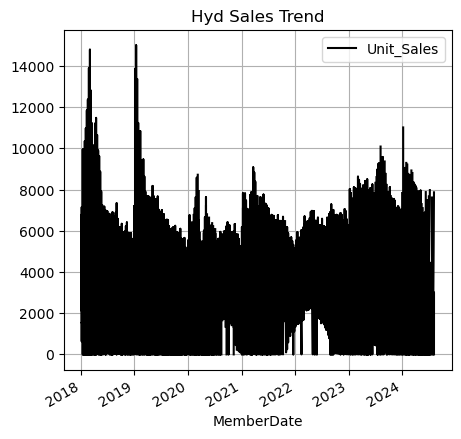

In [10]:
hyd_pos = filtered_pos[filtered_pos['Brand'] == 'HYD']
hyd_pos.plot(kind="line", x="MemberDate", y="Unit_Sales", grid=True, figsize=(5,5),
             title="Hyd Sales Trend", color = 'black')
plt.show()

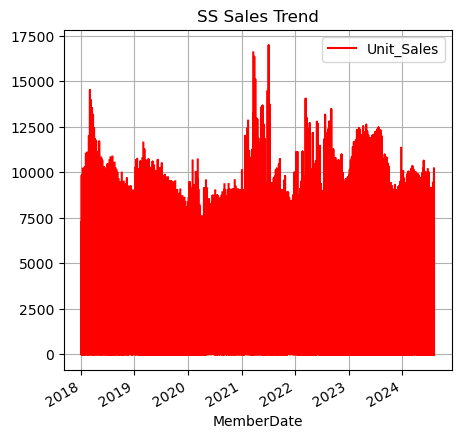

In [11]:
ss_pos = filtered_pos[filtered_pos['Brand'] == 'SS']
ss_pos.plot(kind="line", x="MemberDate", y="Unit_Sales", grid=True, figsize=(5,5),
             title="SS Sales Trend", color = 'red')
plt.show()

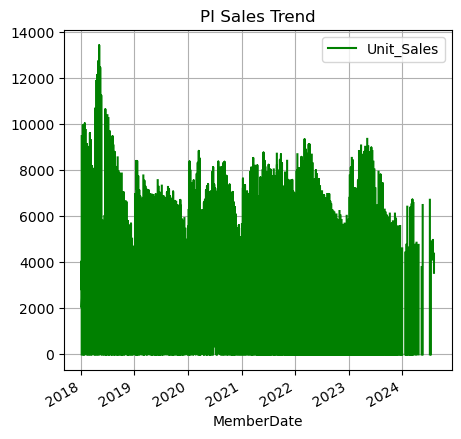

In [12]:
pi_pos = filtered_pos[filtered_pos['Brand'] == 'PI']
pi_pos.plot(kind="line", x="MemberDate", y="Unit_Sales", grid=True, figsize=(5,5),
             title="PI Sales Trend", color = 'green')
plt.show()

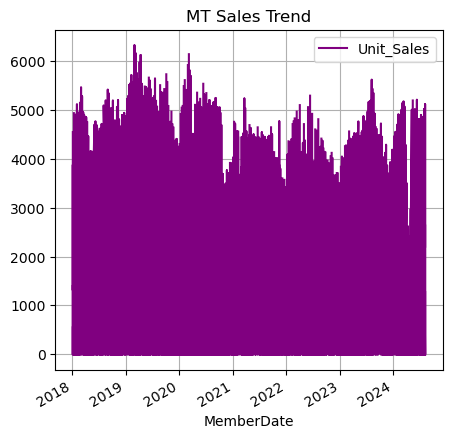

In [13]:
mt_pos = filtered_pos[filtered_pos['Brand'] == 'MT']
mt_pos.plot(kind="line", x="MemberDate", y="Unit_Sales", grid=True, figsize=(5,5),
             title="MT Sales Trend", color = 'purple')
plt.show()

Create a Nueral Network Model using previous years unit sales data to predict future sales

In [14]:
hc_hyd_pos = filtered_pos[filtered_pos['UPC12digit'] == '631656603201']
hc_hyd_pos.head()

,MemberDate,Year,Week,UPC12digit,Brand,ioCategory,ioSubCategory,Unit_Sales,Unit % Chg,YA_Unit_Sales,...,%_Chg_from_MA,Average Weekly ACV Distribution,Number of Stores Selling,U/S/W,Number of Stores Selling YA,U/S/W YA,Sub_Cat_Units,Sub_Cat_%_Chg,Sub_Cat_Units_YA,Sub_Cat_MA_Units
3048,2018-01-07,2018,1,631656603201,HYD,DIET,WEIGHT LOSS,6791.0,0.01,6739.0,...,0.21,75.4,3258.0,2.1,3192.85,2.11,128223.0,-2.99,511280.0,97434.0
3116,2018-01-14,2018,2,631656603201,HYD,DIET,WEIGHT LOSS,7149.0,0.03,6949.0,...,0.23,76.2,3288.0,2.2,3244.89,2.14,145356.0,-0.01,146818.0,102395.0
3186,2018-01-21,2018,3,631656603201,HYD,DIET,WEIGHT LOSS,6864.0,-0.07,7357.0,...,0.10,75.0,3232.0,2.1,3357.76,2.19,136941.0,-0.11,152036.0,114779.0
3255,2018-01-28,2018,4,631656603201,HYD,DIET,WEIGHT LOSS,6966.0,-0.07,7524.0,...,0.07,76.5,3310.0,2.1,3360.91,2.24,150951.0,-0.03,155109.0,125142.0
3321,2018-02-04,2018,5,631656603201,HYD,DIET,WEIGHT LOSS,7232.0,-0.11,8144.0,...,0.04,76.7,3319.0,2.2,3454.91,2.36,154338.0,-0.08,167070.0,140368.0


In [15]:
#Calculate the difference in sales by Year
#hc_hyd_pos['sales_diff'] = hc_hyd_pos['Unit_Sales'].diff()

hc_hyd_pos['sales_diff'] = hc_hyd_pos.groupby('Year')['Unit_Sales'].diff()
hc_hyd_pos = hc_hyd_pos.dropna()
hc_hyd_pos.head()

C:\Users\jennifer.stipe\AppData\Local\Temp\ipykernel_35736\1801855049.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hc_hyd_pos['sales_diff'] = hc_hyd_pos.groupby('Year')['Unit_Sales'].diff()


,MemberDate,Year,Week,UPC12digit,Brand,ioCategory,ioSubCategory,Unit_Sales,Unit % Chg,YA_Unit_Sales,...,Average Weekly ACV Distribution,Number of Stores Selling,U/S/W,Number of Stores Selling YA,U/S/W YA,Sub_Cat_Units,Sub_Cat_%_Chg,Sub_Cat_Units_YA,Sub_Cat_MA_Units,sales_diff
3116,2018-01-14,2018,2,631656603201,HYD,DIET,WEIGHT LOSS,7149.0,0.03,6949.0,...,76.2,3288.0,2.2,3244.89,2.14,145356.0,-0.01,146818.0,102395.0,358.0
3186,2018-01-21,2018,3,631656603201,HYD,DIET,WEIGHT LOSS,6864.0,-0.07,7357.0,...,75.0,3232.0,2.1,3357.76,2.19,136941.0,-0.11,152036.0,114779.0,-285.0
3255,2018-01-28,2018,4,631656603201,HYD,DIET,WEIGHT LOSS,6966.0,-0.07,7524.0,...,76.5,3310.0,2.1,3360.91,2.24,150951.0,-0.03,155109.0,125142.0,102.0
3321,2018-02-04,2018,5,631656603201,HYD,DIET,WEIGHT LOSS,7232.0,-0.11,8144.0,...,76.7,3319.0,2.2,3454.91,2.36,154338.0,-0.08,167070.0,140368.0,266.0
3387,2018-02-11,2018,6,631656603201,HYD,DIET,WEIGHT LOSS,6638.0,-0.19,8154.0,...,74.8,3256.0,2.0,3456.92,2.36,149535.0,-0.09,162527.0,146897.0,-594.0


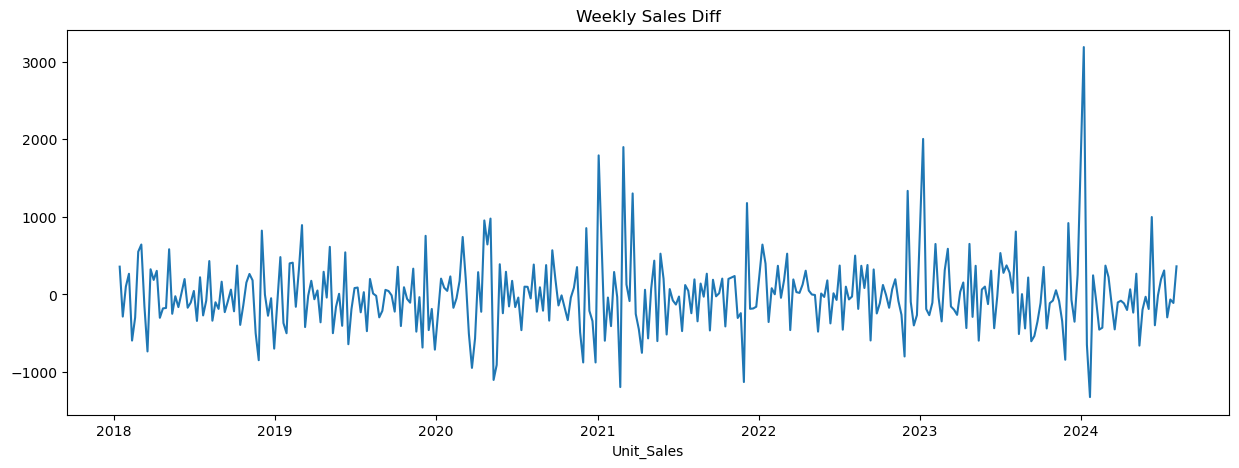

In [16]:
plt.figure(figsize=(15,5))
plt.plot(hc_hyd_pos[['MemberDate']], hc_hyd_pos['sales_diff'])
plt.xlabel('MemberDate')
plt.xlabel('Unit_Sales')
plt.title("Weekly Sales Diff")
plt.show()

LSTM with Pytorch

In [17]:
unit_df = hc_hyd_pos[['sales_diff']].values.astype('float32')
unit_df.shape

(335, 1)

C:\Users\jennifer.stipe\AppData\Local\Temp\ipykernel_35736\2112542258.py:19: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:278.)
  return torch.tensor(X), torch.tensor(y)


Epoch 0: train RMSE 439.804, test RMSE 512.168
Epoch 100: train RMSE 424.810, test RMSE 514.102
Epoch 200: train RMSE 412.325, test RMSE 512.821
Epoch 300: train RMSE 397.483, test RMSE 515.777
Epoch 400: train RMSE 384.135, test RMSE 513.813
Epoch 500: train RMSE 372.876, test RMSE 513.687
Epoch 600: train RMSE 361.991, test RMSE 515.640
Epoch 700: train RMSE 353.281, test RMSE 512.005
Epoch 800: train RMSE 344.549, test RMSE 512.807
Epoch 900: train RMSE 336.579, test RMSE 513.983
Epoch 1000: train RMSE 329.335, test RMSE 514.342
Epoch 1100: train RMSE 326.410, test RMSE 523.004
Epoch 1200: train RMSE 315.890, test RMSE 522.178
Epoch 1300: train RMSE 317.325, test RMSE 527.393
Epoch 1400: train RMSE 306.997, test RMSE 530.679
Epoch 1500: train RMSE 300.570, test RMSE 539.210
Epoch 1600: train RMSE 294.879, test RMSE 537.639
Epoch 1700: train RMSE 290.734, test RMSE 535.124
Epoch 1800: train RMSE 286.152, test RMSE 546.794
Epoch 1900: train RMSE 280.905, test RMSE 541.197


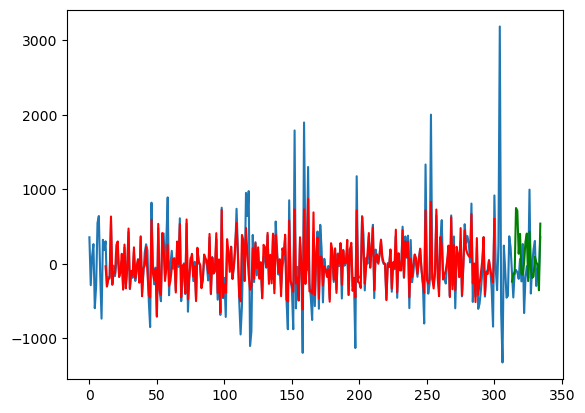

In [18]:
# train-test split for time series
train_size = int(len(unit_df) * 0.90)
test_size = len(unit_df) - train_size
train, test = unit_df[:train_size], unit_df[train_size:]
 
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)
 
lookback = 12
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
 
class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x
 
model = AirModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)
 
n_epochs = 2000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.3f, test RMSE %.3f" % (epoch, train_rmse, test_rmse))
 
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(unit_df) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(unit_df) * np.nan
    test_plot[train_size+lookback:len(unit_df)] = model(X_test)[:, -1, :]
# plot
plt.plot(unit_df)
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()

In [40]:
test_plot

array([[        nan],
       [        nan],
       [        nan],
       [        nan],
       [        nan],
       [        nan],
       [        nan],
       [        nan],
       [        nan],
       [        nan],
       [        nan],
       [        nan],
       [        nan],
       [        nan],
       [        nan],
       [        nan],
       [        nan],
       [        nan],
       [        nan],
       [        nan],
       [        nan],
       [        nan],
       [        nan],
       [        nan],
       [        nan],
       [        nan],
       [        nan],
       [        nan],
       [        nan],
       [        nan],
       [        nan],
       [        nan],
       [        nan],
       [        nan],
       [        nan],
       [        nan],
       [        nan],
       [        nan],
       [        nan],
       [        nan],
       [        nan],
       [        nan],
       [        nan],
       [        nan],
       [        nan],
       [  

Persistence LSTM Model

In [19]:
time_pos = hc_hyd_pos[['MemberDate', 'Year','Unit_Sales']]
time_pos.head()

,MemberDate,Year,Unit_Sales
3116,2018-01-14,2018,7149.0
3186,2018-01-21,2018,6864.0
3255,2018-01-28,2018,6966.0
3321,2018-02-04,2018,7232.0
3387,2018-02-11,2018,6638.0


c:\Users\jennifer.stipe\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
t+1 RMSE: 468.935110
t+2 RMSE: 601.112161
t+3 RMSE: 755.169026
t+4 RMSE: 1054.638515
t+5 RMSE: 1073.035275
t+6 RMSE: 1097.310048
t+7 RMSE: 1141.219924
t+8 RMSE: 1202.791835
t+9 RMSE: 1235.100525
t+10 RMSE: 1300.678391
t+11 RMSE: 1397.770794
t+12 RMSE: 1516.370241
t+13 RMSE: 1546.921777
t+14 RMSE: 1445.470931
t+15 RMSE: 1458.408804
t+16 RMSE: 1464.481366


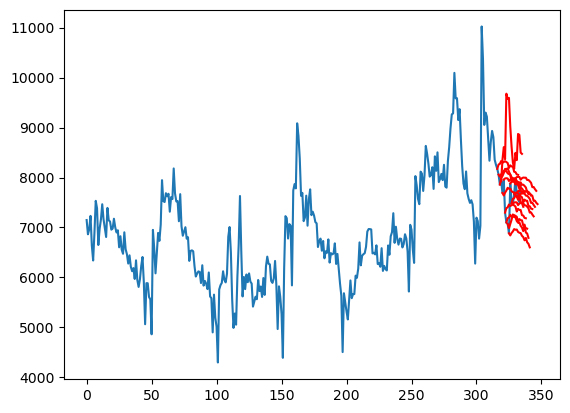

<Figure size 1500x700 with 0 Axes>

In [20]:

# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime('%Y-%m-%d')

# convert time series into supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return time_pos.groupby('Year')['Unit_Sales'].diff()

# transform series into train and test sets for supervised learning
def prepare_data(time_pos, n_test, n_lag, n_seq):
	# extract raw values
	raw_values = time_pos.values
	# transform data to be stationary
	diff_series = difference(raw_values, 1)
	diff_values = diff_series.values
	diff_values = diff_values.reshape(len(diff_values), 1)
	# rescale values to -1, 1
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaled_values = scaler.fit_transform(diff_values)
	scaled_values = scaled_values.reshape(len(scaled_values), 1)
	# transform into supervised learning problem X, y
	supervised = series_to_supervised(scaled_values, n_lag, n_seq)
	supervised_values = supervised.values
	# split into train and test sets
	train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
	return scaler, train, test

# fit an LSTM network to training data
def fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons):
	# reshape training into [samples, timesteps, features]
	X, y = train[:, 0:n_lag], train[:, n_lag:]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	# design network
	model = Sequential()
	model.add(LSTM(n_neurons, input_shape=(X.shape[1], X.shape[2])))
	model.add(Dense(y.shape[1]))
	model.compile(loss='mean_squared_error', optimizer='adam')
	# fit network
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=n_batch, verbose=0, shuffle=False)
	#	model.reset_states()
	return model

# make one forecast with an LSTM,
def forecast_lstm(model, X, n_batch):
	# reshape input pattern to [samples, timesteps, features]
	X = X.reshape(1, 1, len(X))
	# make forecast
	forecast = model.predict(X, batch_size=n_batch)
	# convert to array
	return [x for x in forecast[0, :]]

# evaluate the persistence model
def make_forecasts(model, n_batch, train, test, n_lag, n_seq):
	forecasts = list()
	for i in range(len(test)):
		X, y = test[i, 0:n_lag], test[i, n_lag:]
		# make forecast
		forecast = forecast_lstm(model, X, n_batch)
		# store the forecast
		forecasts.append(forecast)
	return forecasts

# invert differenced forecast
def inverse_difference(last_ob, forecast):
	# invert first forecast
	inverted = list()
	inverted.append(forecast[0] + last_ob)
	# propagate difference forecast using inverted first value
	for i in range(1, len(forecast)):
		inverted.append(forecast[i] + inverted[i-1])
	return inverted

# inverse data transform on forecasts
def inverse_transform(series, forecasts, scaler, n_test):
	inverted = list()
	for i in range(len(forecasts)):
		# create array from forecast
		forecast = array(forecasts[i])
		forecast = forecast.reshape(1, len(forecast))
		# invert scaling
		inv_scale = scaler.inverse_transform(forecast)
		inv_scale = inv_scale[0, :]
		# invert differencing
		index = len(series) - n_test + i - 1
		last_ob = series['Unit_Sales'].values[index]
		inv_diff = inverse_difference(last_ob, inv_scale)
		# store
		inverted.append(inv_diff)
	return inverted

# evaluate the RMSE for each forecast time step
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
	for i in range(n_seq):
		actual = [row[i] for row in test]
		predicted = [forecast[i] for forecast in forecasts]
		rmse = sqrt(mean_squared_error(actual, predicted))
		print('t+%d RMSE: %f' % ((i+1), rmse))

# plot the forecasts in the context of the original dataset
def plot_forecasts(series, forecasts, n_test):
	# plot the entire dataset in blue
	pyplot.plot(series['Unit_Sales'].values)
	# plot the forecasts in red
	for i in range(len(forecasts)):
		off_s = len(series) - n_test + i - 1
		off_e = off_s + len(forecasts[i]) + 1
		xaxis = [x for x in range(off_s, off_e)]
		yaxis = [series['Unit_Sales'].values[off_s]] + forecasts[i]
		pyplot.plot(xaxis, yaxis, color='red')
	# show the plot
	plt.figure(figsize=(15,7))
	pyplot.show()

series = time_pos

# configure
n_lag = 1
n_seq = 16
n_test = 16
n_epochs = 3000
n_batch = 1
n_neurons = 4
# prepare data
scaler, train, test = prepare_data(series, n_test, n_lag, n_seq)
# fit model
model = fit_lstm(train, n_lag, n_seq, n_batch, n_epochs, n_neurons)
# make forecasts
forecasts = make_forecasts(model, n_batch, train, test, n_lag, n_seq)
# inverse transform forecasts and test
forecasts = inverse_transform(series, forecasts, scaler, n_test+2)
actual = [row[n_lag:] for row in test]
actual = inverse_transform(series, actual, scaler, n_test+2)
# evaluate forecasts
evaluate_forecasts(actual, forecasts, n_lag, n_seq)
# plot forecasts
plot_forecasts(series, forecasts, n_test+2)

In [21]:
forecasts

[[8259.792823791504,
  8273.087388038635,
  8328.571167945862,
  8295.099659919739,
  8310.21513080597,
  8325.737318992615,
  8309.545018196106,
  8289.702193260193,
  8191.8369817733765,
  8243.756556510925,
  8220.687104225159,
  8219.314106225967,
  8115.195797204971,
  8107.616553068161,
  8061.956843137741,
  8053.106155157089],
 [8016.787166595459,
  8064.406234741211,
  8092.706464767456,
  8136.715532302856,
  8125.089484214783,
  8129.480244636536,
  8083.639904975891,
  8067.321026802063,
  8059.481697559357,
  8006.734554767609,
  7981.642912387848,
  7917.483862400055,
  7960.686956882477,
  7877.278044223785,
  7846.0380692481995,
  7775.798056125641],
 [7991.087493896484,
  8028.827892303467,
  8088.821571350098,
  8172.261573791504,
  8168.564556121826,
  8183.374263763428,
  8117.39879989624,
  8057.634162902832,
  7923.247123718262,
  7981.5602684021,
  7983.934620141983,
  7983.868428766727,
  7928.141934931278,
  7909.823203623295,
  7839.423484385014,
  7838.325181

Additional Pre-Processing for Linear, Random Forest, and XG Boost

In [22]:
# Select categorization and YA unit sales columns to use as X data
Selected_Columns = hc_hyd_pos[['sales_diff']]
Selected_Columns.head()

,sales_diff
3116,358.0
3186,-285.0
3255,102.0
3321,266.0
3387,-594.0


In [23]:
#Capture sales_diff for the past 6 years in weeks
for i in range(1,312):
    col_name = 'week_' + str(i)
    Selected_Columns[col_name] = Selected_Columns['sales_diff'].shift(i)
Selected_Columns = Selected_Columns.dropna().reset_index(drop=True)
Selected_Columns.head(10)

C:\Users\jennifer.stipe\AppData\Local\Temp\ipykernel_35736\446271890.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Selected_Columns[col_name] = Selected_Columns['sales_diff'].shift(i)
C:\Users\jennifer.stipe\AppData\Local\Temp\ipykernel_35736\446271890.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Selected_Columns[col_name] = Selected_Columns['sales_diff'].shift(i)
C:\Users\jennifer.stipe\AppData\Local\Temp\ipykernel_35736\446271890.py:4: SettingWithCopyWarning: 
A value is trying to be set on a

,sales_diff,week_1,week_2,week_3,week_4,week_5,week_6,week_7,week_8,week_9,...,week_302,week_303,week_304,week_305,week_306,week_307,week_308,week_309,week_310,week_311
0,371.0,-428.0,-453.0,-81.0,246.0,-1322.0,-647.0,3186.0,255.0,-351.0,...,-734.0,-149.0,643.0,550.0,-298.0,-594.0,266.0,102.0,-285.0,358.0
1,224.0,371.0,-428.0,-453.0,-81.0,246.0,-1322.0,-647.0,3186.0,255.0,...,324.0,-734.0,-149.0,643.0,550.0,-298.0,-594.0,266.0,102.0,-285.0
2,-124.0,224.0,371.0,-428.0,-453.0,-81.0,246.0,-1322.0,-647.0,3186.0,...,187.0,324.0,-734.0,-149.0,643.0,550.0,-298.0,-594.0,266.0,102.0
3,-450.0,-124.0,224.0,371.0,-428.0,-453.0,-81.0,246.0,-1322.0,-647.0,...,304.0,187.0,324.0,-734.0,-149.0,643.0,550.0,-298.0,-594.0,266.0
4,-103.0,-450.0,-124.0,224.0,371.0,-428.0,-453.0,-81.0,246.0,-1322.0,...,-301.0,304.0,187.0,324.0,-734.0,-149.0,643.0,550.0,-298.0,-594.0
5,-81.0,-103.0,-450.0,-124.0,224.0,371.0,-428.0,-453.0,-81.0,246.0,...,-180.0,-301.0,304.0,187.0,324.0,-734.0,-149.0,643.0,550.0,-298.0
6,-115.0,-81.0,-103.0,-450.0,-124.0,224.0,371.0,-428.0,-453.0,-81.0,...,-174.0,-180.0,-301.0,304.0,187.0,324.0,-734.0,-149.0,643.0,550.0
7,-200.0,-115.0,-81.0,-103.0,-450.0,-124.0,224.0,371.0,-428.0,-453.0,...,582.0,-174.0,-180.0,-301.0,304.0,187.0,324.0,-734.0,-149.0,643.0
8,66.0,-200.0,-115.0,-81.0,-103.0,-450.0,-124.0,224.0,371.0,-428.0,...,-249.0,582.0,-174.0,-180.0,-301.0,304.0,187.0,324.0,-734.0,-149.0
9,-234.0,66.0,-200.0,-115.0,-81.0,-103.0,-450.0,-124.0,224.0,371.0,...,-23.0,-249.0,582.0,-174.0,-180.0,-301.0,304.0,187.0,324.0,-734.0


In [24]:
#Split the data into train and test
train_data = Selected_Columns[:-16]
test_data = Selected_Columns[-16:]
print('Train Data Shape:', train_data.shape)
print('Test Data Shape:', test_data.shape)

Train Data Shape: (8, 312)
Test Data Shape: (16, 312)


In [25]:
#Scale the data
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(train_data)



MinMaxScaler(feature_range=(-1, 1))

In [26]:
#transform the data
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [27]:
#Split the data into X and y
X_train, y_train = train_data[:,1:], train_data[:,0:1]
X_test, y_test = test_data[:,1:], test_data[:,0:1]
y_train = y_train.ravel()
y_test = y_test.ravel()
print('X_train Shape:', X_train.shape)
print('y_train Shape:', y_train.shape)
print('X_test Shape:', X_test.shape)
print('y_test Shape:', y_test.shape)

X_train Shape: (8, 311)
y_train Shape: (8,)
X_test Shape: (16, 311)
y_test Shape: (16,)


In [28]:
#Create a dataframe for the predictions
sales_dates = hc_hyd_pos['MemberDate'][-16:].reset_index(drop=True)
predict_df = pd.DataFrame(sales_dates)
predict_df

,MemberDate
0,2024-04-21
1,2024-04-28
2,2024-05-05
3,2024-05-12
4,2024-05-19
5,2024-05-26
6,2024-06-02
7,2024-06-09
8,2024-06-16
9,2024-06-23


In [29]:
#Capture the actual sales for the last 12 weeks to compare to the predictions
act_sales = hc_hyd_pos['Unit_Sales'][-16:].to_list()
act_sales

[7924.0,
 7690.0,
 7957.0,
 7298.0,
 7101.0,
 7071.0,
 6884.0,
 7881.0,
 7484.0,
 7472.0,
 7669.0,
 7978.0,
 7683.0,
 7618.0,
 7508.0,
 7870.0]

Linear Regression Test

In [30]:
#Fit Linear Regression Model
linreg_model = LinearRegression()
linreg_model.fit(X_train, y_train)
linreg_pred = linreg_model.predict(X_test)

#Transform
linreg_pred = linreg_pred.reshape(-1,1)
linreg_pred_test_set = np.concatenate([linreg_pred,X_test], axis=1)
linreg_pred_test_set = scaler.inverse_transform(linreg_pred_test_set)

#Predict
result_list = []
for index in range(0, len(linreg_pred_test_set)):
    result_list.append(linreg_pred_test_set[index][0] + act_sales[index])
linreg_pred_series = pd.Series(result_list,name='linreg_pred')
predict_df = predict_df.merge(linreg_pred_series, left_index=True, right_index=True)

#Results
linreg_rmse = np.sqrt(mean_squared_error(predict_df['linreg_pred'], hc_hyd_pos['Unit_Sales'][-16:]))
linreg_mae = mean_absolute_error(predict_df['linreg_pred'], hc_hyd_pos['Unit_Sales'][-16:])
linreg_r2 = r2_score(predict_df['linreg_pred'], hc_hyd_pos['Unit_Sales'][-16:])
print('Linear Regression RMSE: ', linreg_rmse)
print('Linear Regression MAE: ', linreg_mae)
print('Linear Regression R2 Score: ', linreg_r2)



Linear Regression RMSE:  103.99731309297417
Linear Regression MAE:  81.711360815935
Linear Regression R2 Score:  0.9067620440268845


In [31]:
#Print Predictions
predict_df

,MemberDate,linreg_pred
0,2024-04-21,7817.598900
1,2024-04-28,7745.223094
2,2024-05-05,7852.731768
3,2024-05-12,7180.520504
4,2024-05-19,6937.586318
5,2024-05-26,7082.792076
6,2024-06-02,6838.228905
7,2024-06-09,7772.073375
8,2024-06-16,7236.214070
9,2024-06-23,7391.222110


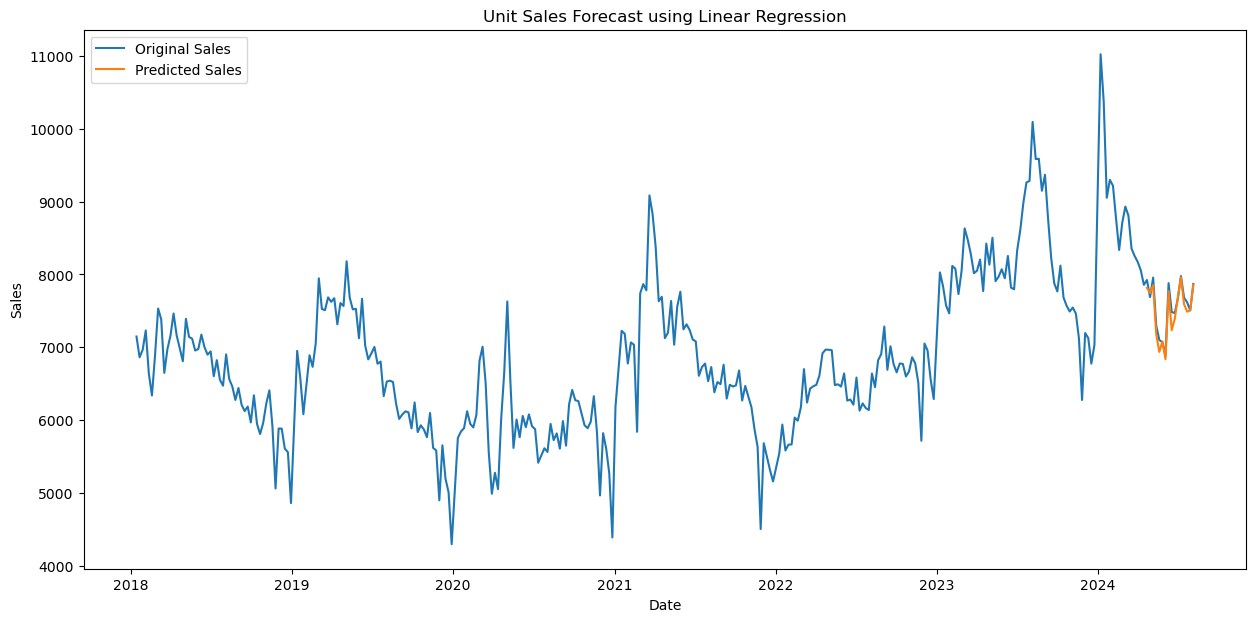

In [32]:
#Visualize Linear Regression Results
plt.figure(figsize=(15,7))
plt.plot(hc_hyd_pos[['MemberDate']], hc_hyd_pos['Unit_Sales'])
plt.plot(predict_df['MemberDate'], predict_df['linreg_pred'])
plt.title("Unit Sales Forecast using Linear Regression")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend(["Original Sales", "Predicted Sales"])
plt.show()

Random Forest Regressor Test

In [33]:
#Fit Linear Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100, max_depth=20)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

#Transform
rf_pred = rf_pred.reshape(-1,1)
rf_pred_test_set = np.concatenate([rf_pred,X_test], axis=1)
rf_pred_test_set = scaler.inverse_transform(rf_pred_test_set)

#Predict
result_list = []
for index in range(0, len(rf_pred_test_set)):
    result_list.append(rf_pred_test_set[index][0] + act_sales[index])
rf_pred_series = pd.Series(result_list, name='rf_pred')
predict_df = predict_df.merge(rf_pred_series, left_index=True, right_index=True)

# Results
rf_rmse = np.sqrt(mean_squared_error(predict_df['rf_pred'], hc_hyd_pos['Unit_Sales'][-16:]))
rf_mae = mean_absolute_error(predict_df['rf_pred'], hc_hyd_pos['Unit_Sales'][-16:])
rf_r2 = r2_score(predict_df['rf_pred'], hc_hyd_pos['Unit_Sales'][-16:])
print('Random Forest RMSE: ', rf_rmse)
print('Random Forest MAE: ', rf_mae)
print('Random Forest R2 Score: ', rf_r2)

Random Forest RMSE:  61.24999617346919
Random Forest MAE:  55.84312499999993
Random Forest R2 Score:  0.9659449839813006


In [34]:
#Print predictions
predict_df

,MemberDate,linreg_pred,rf_pred
0,2024-04-21,7817.598900,7853.45
1,2024-04-28,7745.223094,7637.64
2,2024-05-05,7852.731768,7894.87
3,2024-05-12,7180.520504,7193.56
4,2024-05-19,6937.586318,7044.62
5,2024-05-26,7082.792076,7029.43
6,2024-06-02,6838.228905,6812.78
7,2024-06-09,7772.073375,7814.38
8,2024-06-16,7236.214070,7409.64
9,2024-06-23,7391.222110,7423.24


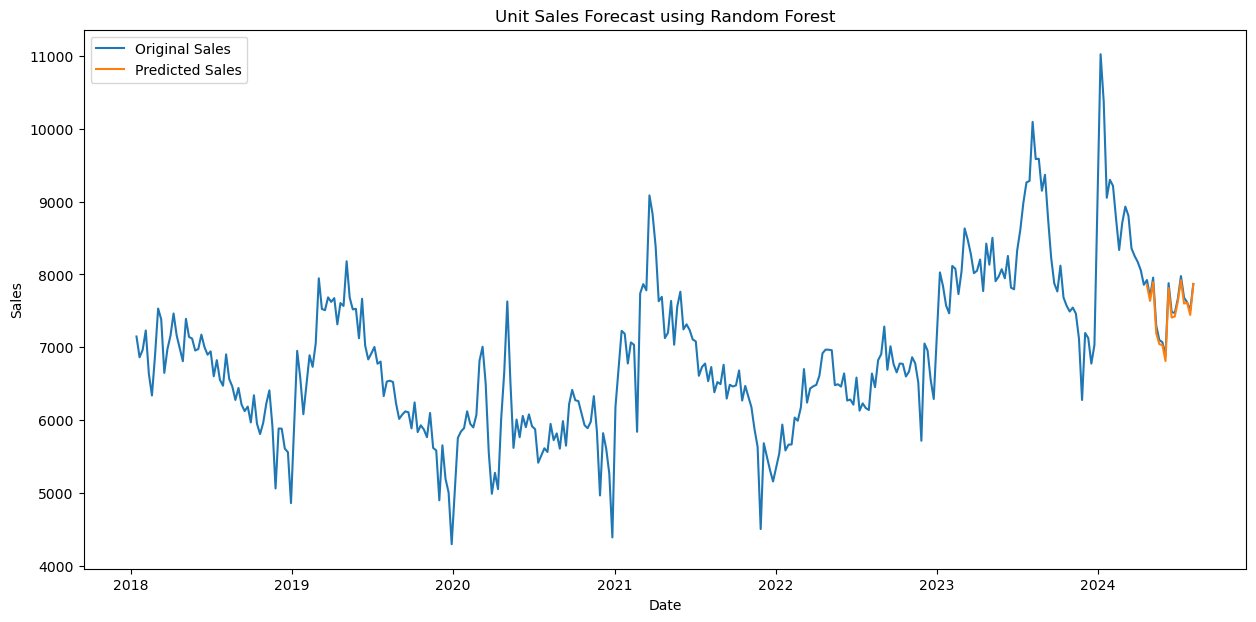

In [35]:
#Visualize Random Forest Model
plt.figure(figsize=(15,7))
plt.plot(hc_hyd_pos[['MemberDate']], hc_hyd_pos['Unit_Sales'])
plt.plot(predict_df['MemberDate'], predict_df['rf_pred'])
plt.title("Unit Sales Forecast using Random Forest")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend(["Original Sales", "Predicted Sales"])
plt.show()

Forecast Sales using XGBoost Regressor

In [36]:
#Train XGBoost Model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.2, objective='reg:squarederror')
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

#Transform XGBoost Model
xgb_pred = xgb_pred.reshape(-1,1)
xgb_pred_test_set = np.concatenate([xgb_pred,X_test], axis=1)
xgb_pred_test_set = scaler.inverse_transform(xgb_pred_test_set)

#Predict XGBoost Model
result_list = []
for index in range(0, len(xgb_pred_test_set)):
    result_list.append(xgb_pred_test_set[index][0] + act_sales[index])
xgb_pred_series = pd.Series(result_list, name='xgb_pred')
predict_df = predict_df.merge(xgb_pred_series, left_index=True, right_index=True)

#Results
xgb_rmse = np.sqrt(mean_squared_error(predict_df['xgb_pred'], hc_hyd_pos['Unit_Sales'][-16:]))
xgb_mae = mean_absolute_error(predict_df['xgb_pred'], hc_hyd_pos['Unit_Sales'][-16:])
xgb_r2 = r2_score(predict_df['xgb_pred'], hc_hyd_pos['Unit_Sales'][-16:])
print('XG Boost RMSE: ', xgb_rmse)
print('XG Boost MAE: ', xgb_mae)
print('XG Boost R2 Score: ', xgb_r2)

XG Boost RMSE:  174.50351015518427
XG Boost MAE:  150.07035218714736
XG Boost R2 Score:  0.7318185511902915


In [37]:
#Print Predictions
predict_df

,MemberDate,linreg_pred,rf_pred,xgb_pred
0,2024-04-21,7817.598900,7853.45,7820.965642
1,2024-04-28,7745.223094,7637.64,7583.739942
2,2024-05-05,7852.731768,7894.87,7836.008719
3,2024-05-12,7180.520504,7193.56,7191.739942
4,2024-05-19,6937.586318,7044.62,6980.008719
5,2024-05-26,7082.792076,7029.43,6991.320995
6,2024-06-02,6838.228905,6812.78,6777.739942
7,2024-06-09,7772.073375,7814.38,7760.008719
8,2024-06-16,7236.214070,7409.64,7377.739942
9,2024-06-23,7391.222110,7423.24,7840.387338


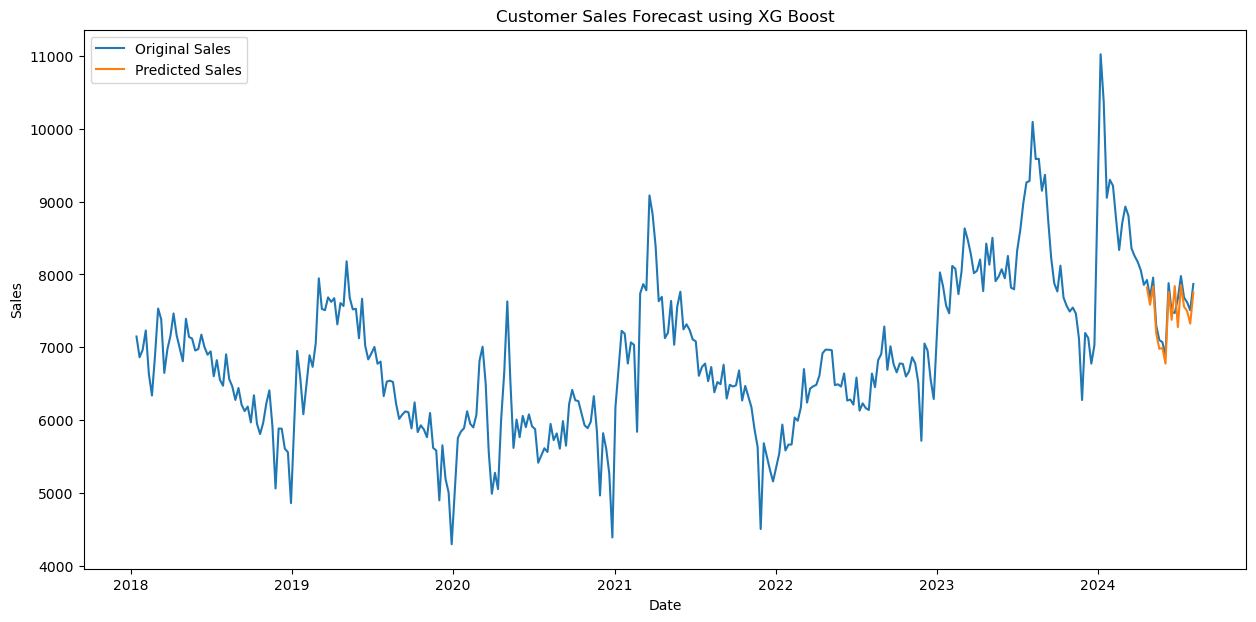

In [38]:
#Plot XG Boot Model
plt.figure(figsize=(15,7))
plt.plot(hc_hyd_pos[['MemberDate']], hc_hyd_pos['Unit_Sales'])
plt.plot(predict_df['MemberDate'], predict_df['xgb_pred'])
plt.title("Customer Sales Forecast using XG Boost")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend(["Original Sales", "Predicted Sales"])
plt.show()